# PyMC and Universal Samplers

## Part A: `import pymc`

In [1]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [2]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.20.1


In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

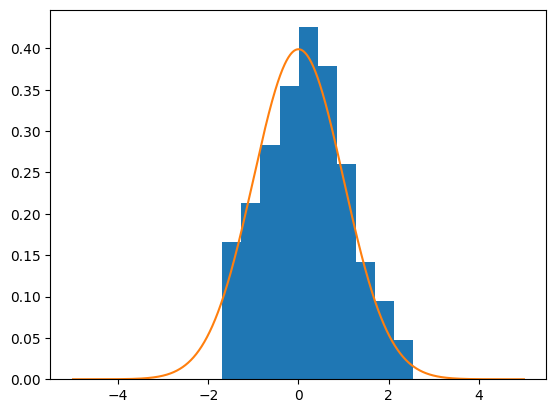

In [4]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [5]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau  
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

In [8]:
# pymc.model_to_graphviz(conjugate_normal_gamma)

In [9]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.09        3            1900.19 draws/s   0:00:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.11        1            1800.47 draws/s   0:00:05   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [10]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [11]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    theta    (chain, draw) float64 160kB 0.1785 0.2206 0.1129 ... 0.3149 0.2775
    tau      (chain, draw) float64 160kB 1.367 1.023 0.9855 ... 1.357 1.257
Attributes:
    created_at:                 2025-02-13T08:00:15.692556+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              9.996844053268433
    tuning_steps:               100

In [12]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[0.17854092, 0.22060046, 0.11292808, ..., 0.0473412 , 0.07521244,
        0.34678862],
       [0.04869706, 0.28055198, 0.1316006 , ..., 0.16676348, 0.31490955,
        0.27746972]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [13]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.36660664, 1.02342091, 0.98546316, ..., 1.02486196, 1.03112286,
        1.02860045],
       [1.0461065 , 1.19202886, 1.22162251, ..., 0.89067079, 1.3567031 ,
        1.25717838]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

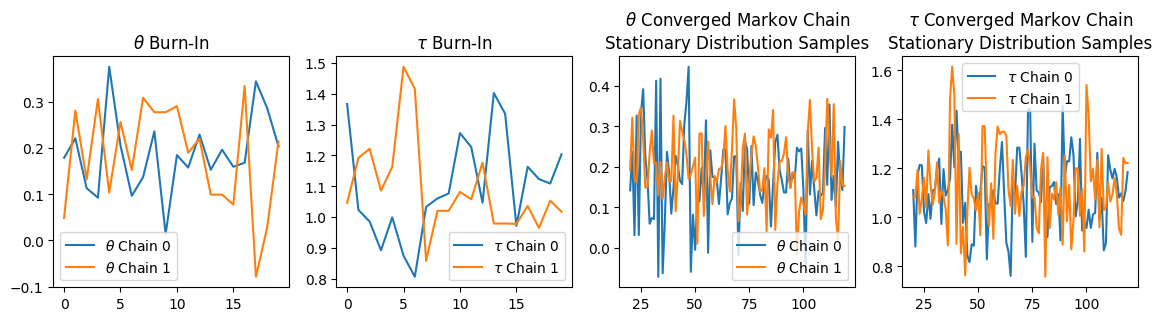

In [14]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

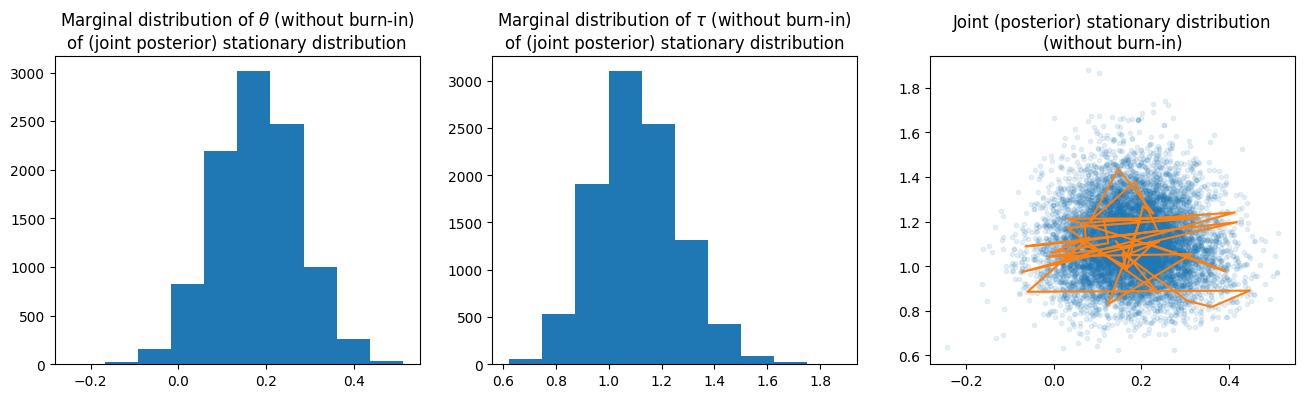

In [15]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [16]:
import arviz as az

In [17]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

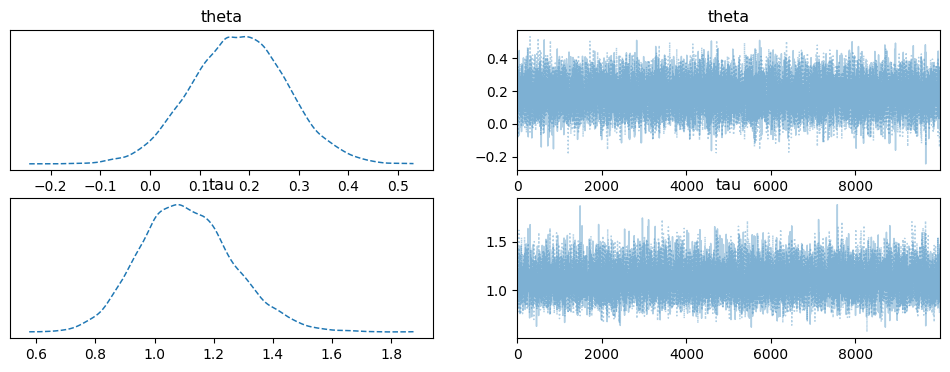

In [18]:
az.plot_trace(idata, combined=True);

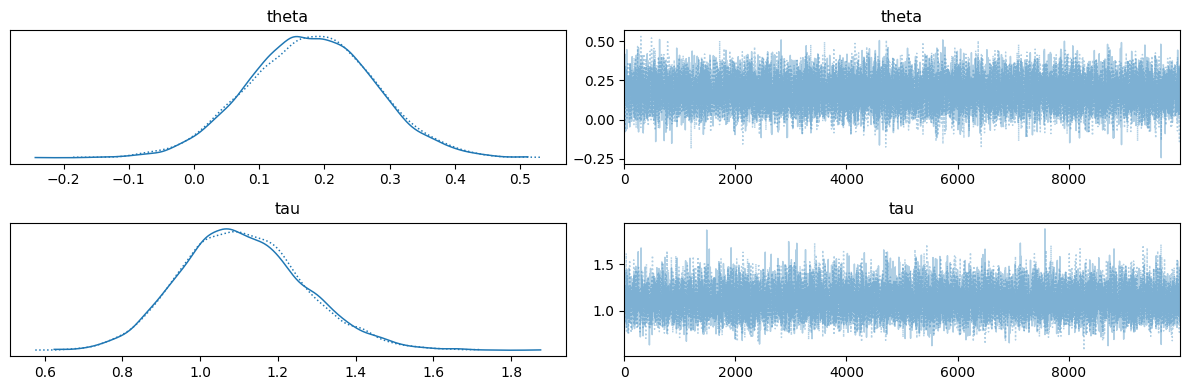

In [19]:
az.plot_trace(idata)
plt.tight_layout()

In [20]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape    

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   1100    0             0.12        3            1831.21 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   1100    0             0.13        1            660.47 draws/s    0:00:01   0:00:00

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [21]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

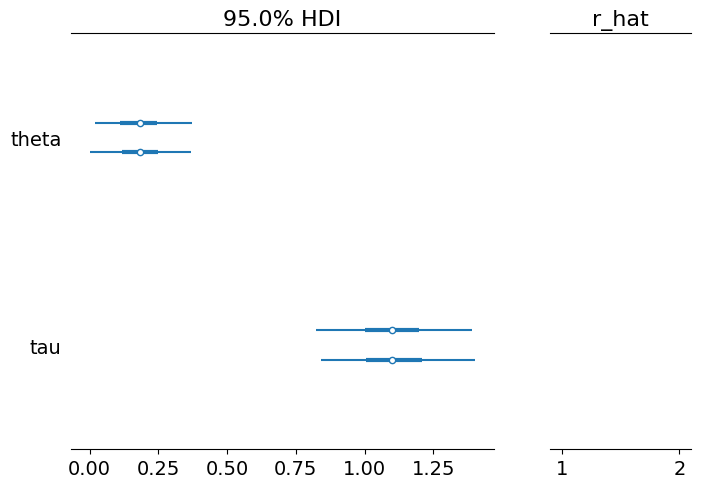

In [22]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [23]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.18059  0.09441 -0.00024  0.34769    0.00206  0.00147  2125.86945   
tau    1.10741  0.14781  0.83462  1.37436    0.00391  0.00279  1444.24678   

         ess_tail    r_hat  
theta  1454.27845  1.00274  
tau    1316.44100  1.00014

In [24]:
theta.ravel().shape

(2000,)

### `mean` and `sd`

In [25]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(0.18059, 1.10741)

In [26]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

(0.09441, 0.14781)

### `hdi_3%` and `hdi_97%`

In [27]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.18059  0.09441 -0.00024  0.34769    0.00206  0.00147  2125.86945   
tau    1.10741  0.14781  0.83462  1.37436    0.00391  0.00279  1444.24678   

         ess_tail    r_hat  
theta  1454.27845  1.00274  
tau    1316.44100  1.00014

In [28]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([0.02704, 0.33523])

In [29]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([0.00046, 0.36277])

In [30]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([0.00746, 0.3553 ])

In [31]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.01004,  0.34167])

In [32]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.83682, 1.37964])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [33]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.18059  0.09441 -0.00024  0.34769    0.00206  0.00147  2125.86945   
tau    1.10741  0.14781  0.83462  1.37436    0.00391  0.00279  1444.24678   

         ess_tail    r_hat  
theta  1454.27845  1.00274  
tau    1316.44100  1.00014

In [34]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

0.0020476215999052113

In [35]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

0.003889404506149984

In [36]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


7.06962683455932e-08

In [37]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method 
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the 
#  standard deviation (SD) of a single variable 
#  without assuming normality using moments of moments 
#  and first order Taylor series approximation 
#  (Kenney and Keeping, 1951, p. 141)."

0.002817039788629601

In [38]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.005574904611662057

In [39]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.18059  0.09441 -0.00024  0.34769    0.00206  0.00147  2125.86945   
tau    1.10741  0.14781  0.83462  1.37436    0.00391  0.00279  1444.24678   

         ess_tail    r_hat  
theta  1454.27845  1.00274  
tau    1316.44100  1.00014

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [40]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

0.05


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1470.2088476900628

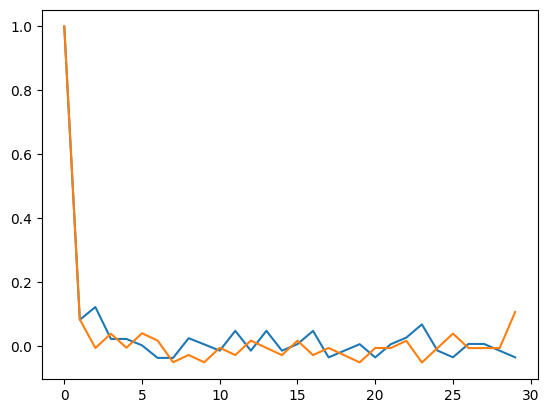

In [41]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k], 
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [42]:
autocorrelations[:,:10]

array([[ 1.        ,  0.08344968,  0.12325047,  0.02356492,  0.02350987,
         0.00352522, -0.03564889, -0.03570705,  0.02588451,  0.0066347 ],
       [ 1.        ,  0.08459235, -0.00476542,  0.03984323, -0.00385058,
         0.04122197,  0.01861259, -0.04912553, -0.02661317, -0.04922956]])

In [43]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

0.1


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

1347.0030056009737

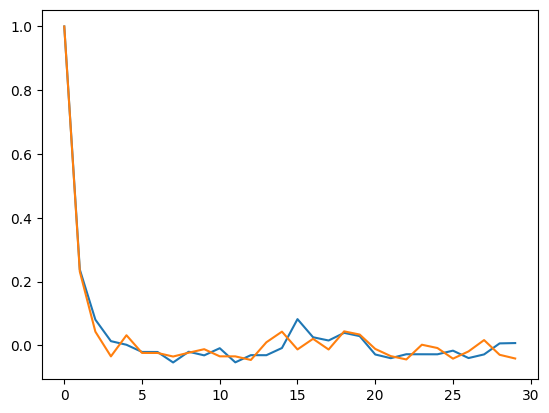

In [44]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k], 
                    tau_in_tail[c,t_plus_k:])[0,1]
        
for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [45]:
autocorrelations[:,:20]

array([[ 1.        ,  0.23757576,  0.08050471,  0.01311557,  0.00179048,
        -0.02075442, -0.0208679 , -0.05376411, -0.02006622, -0.03145258,
        -0.00901931, -0.05334805, -0.03080878, -0.03092378, -0.00837744,
         0.08216617,  0.02539637,  0.01516347,  0.03916038,  0.02890117],
       [ 1.        ,  0.23111224,  0.04292796, -0.0346404 ,  0.03164563,
        -0.02380525, -0.02392099, -0.03510782, -0.02313901, -0.01213244,
        -0.03449438, -0.03461192, -0.04585586,  0.00966178,  0.04293454,
        -0.01282486,  0.02045249, -0.01305776,  0.04382307,  0.03380746]])

In [46]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.18059  0.09441 -0.00024  0.34769    0.00206  0.00147  2125.86945   
tau    1.10741  0.14781  0.83462  1.37436    0.00391  0.00279  1444.24678   

         ess_tail    r_hat  
theta  1454.27845  1.00274  
tau    1316.44100  1.00014

#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


2092.6686691384957

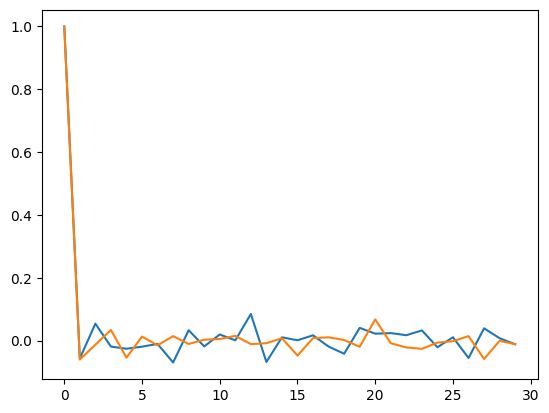

In [47]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k], 
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [48]:
autocorrelations[:,:10]

array([[ 1.        , -0.05705786,  0.05388165, -0.01907712, -0.02598093,
        -0.01937682, -0.01068354, -0.06971724,  0.03305778, -0.01854186],
       [ 1.        , -0.06033664, -0.01319527,  0.03382024, -0.05445781,
         0.01268237, -0.01511834,  0.01411675, -0.01082055,  0.00283536]])

1611.4445020827607

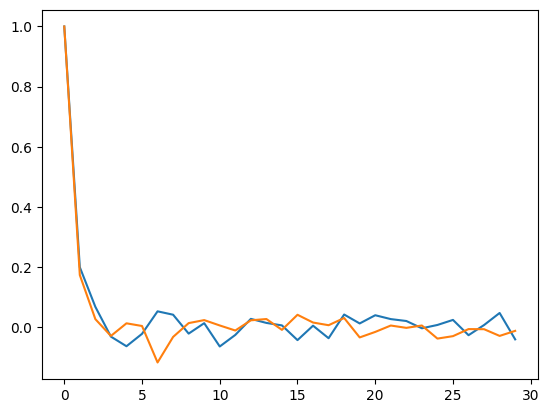

In [49]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [50]:
autocorrelations[:,:10]

array([[ 1.        ,  0.19997708,  0.06824565, -0.03069518, -0.06266377,
        -0.02146107,  0.05334236,  0.0421033 , -0.02069395,  0.0140108 ],
       [ 1.        ,  0.17387827,  0.02739866, -0.02845127,  0.01352572,
         0.00462447, -0.11662909, -0.03171812,  0.01418989,  0.02421079]])

In [51]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.18059  0.09441 -0.00024  0.34769    0.00206  0.00147  2125.86945   
tau    1.10741  0.14781  0.83462  1.37436    0.00391  0.00279  1444.24678   

         ess_tail    r_hat  
theta  1454.27845  1.00274  
tau    1316.44100  1.00014

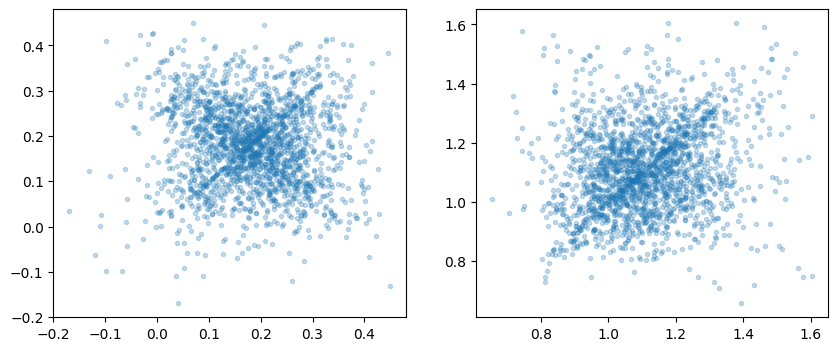

In [52]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [53]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.18059  0.09441 -0.00024  0.34769    0.00206  0.00147  2125.86945   
tau    1.10741  0.14781  0.83462  1.37436    0.00391  0.00279  1444.24678   

         ess_tail    r_hat  
theta  1454.27845  1.00274  
tau    1316.44100  1.00014

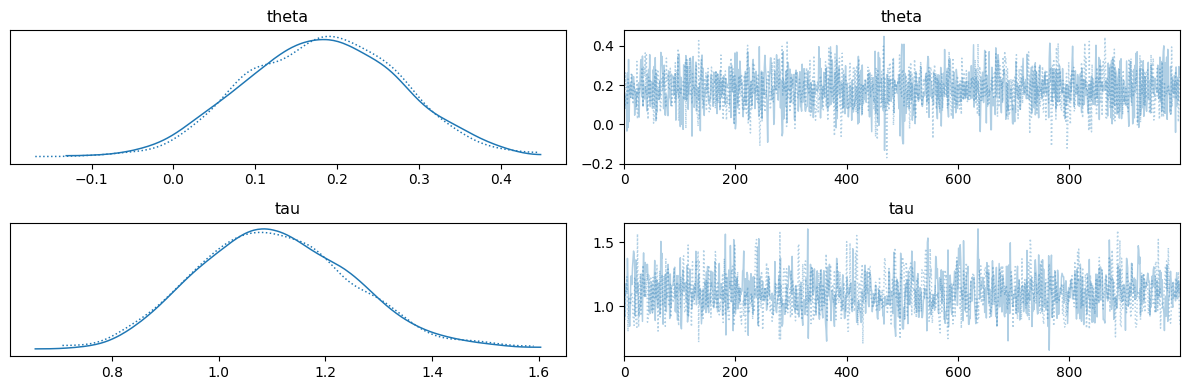

In [54]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


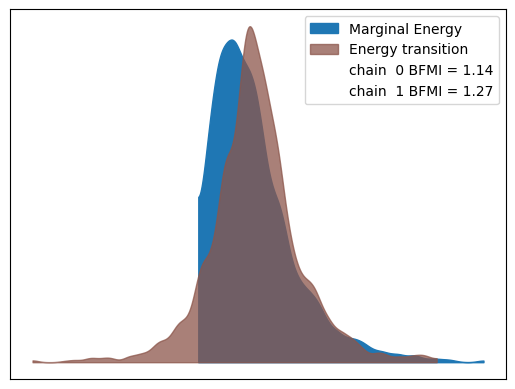

In [55]:
az.plot_energy(idata);

## Part D: Samplers


In [76]:
# pymc.sample?

 Progress                                   Draws   Sampling Speed    Elapsed   Remaining  
 ────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    2744.30 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    2594.70 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    2192.75 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    1096.56 draws/s   0:00:01   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.10   -0.01     0.35        0.0      0.0   1843.04   2580.03   
tau    1.11  0.15    0.82     1.39        0.0      0.0   1877.06   2224.16   

       r_hat  
theta    1.0  
tau      1.0

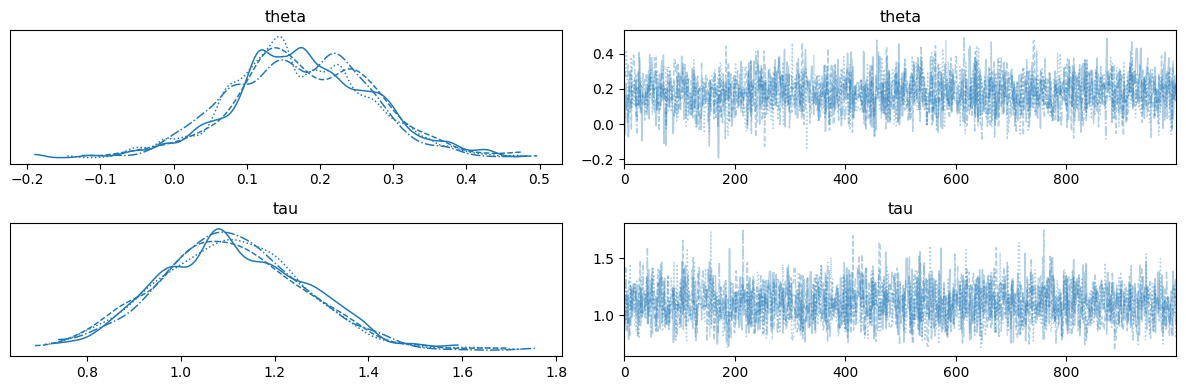

In [57]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)
    
display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()    

In [58]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.37837838, 0.35435435, 0.34334334, 0.32332332])

In [59]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.37837838, 0.35435435, 0.34334334, 0.32332332])

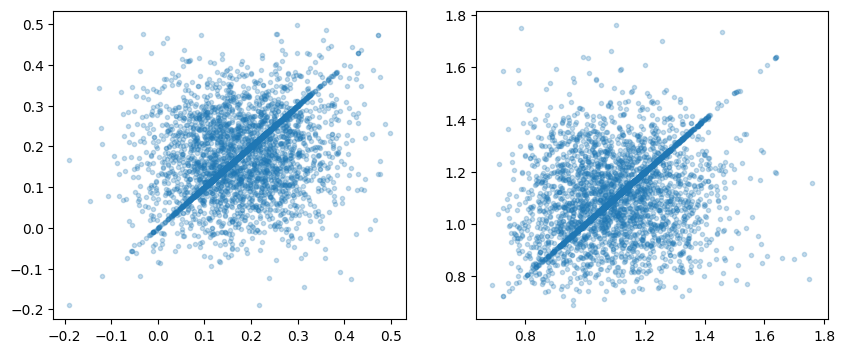

In [60]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1], 
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1], 
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.94        1            1911.38 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.89        7            1809.59 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.83        3            1753.76 draws/s   0:00:01   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.99        3            955.17 draws/s    0:00:02   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.09    0.00     0.35        0.0      0.0   3423.01   2891.18   
tau    1.11  0.16    0.83     1.41        0.0      0.0   3629.59   2892.34   

       r_hat  
theta    1.0  
tau      1.0

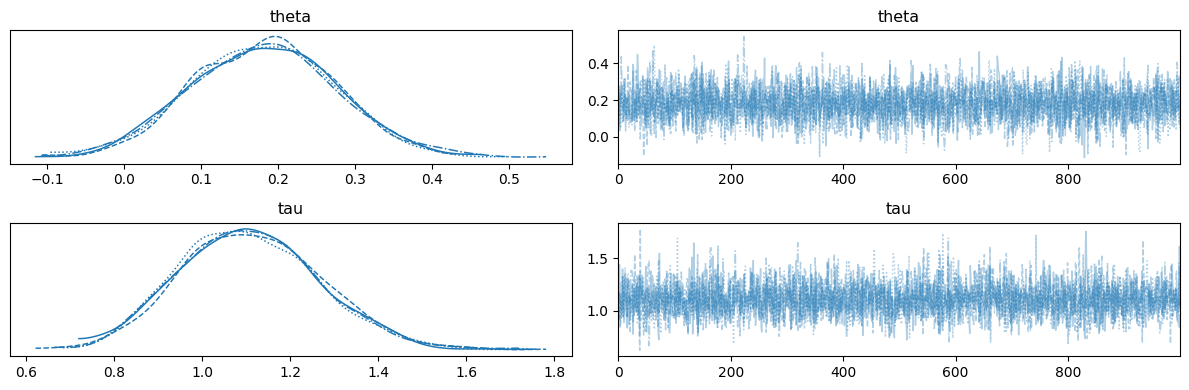

In [61]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)
    
display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()    

In [62]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

0         1         2         3         4         5         6    \
0  0.964772  0.969836  0.571585  0.937335  0.971620  0.890935  1.000000   
1  1.000000  0.997392  0.998673  0.934308  0.852768  1.000000  0.990654   
2  0.882570  0.926928  0.941154  0.973566  0.945570  1.000000  0.969145   
3  0.989263  0.985516  0.964747  0.701798  0.971710  0.657766  0.823887   

        7         8         9    ...       990      991      992       993  \
0  0.898465  0.599814  1.000000  ...  0.994040  0.83480  1.00000  0.992608   
1  0.895818  0.997394  0.740158  ...  0.968180  0.88411  0.87220  0.796413   
2  0.981000  0.997647  0.950447  ...  0.981609  0.90562  0.99959  1.000000   
3  0.849934  1.000000  0.941626  ...  1.000000  0.99090  0.92609  0.969720   

        994       995       996       997       998       999  
0  0.792123  0.993152  0.994116  0.908139  0.322929  1.000000  
1  1.000000  0.899683  0.737270  1.000000  0.911407  0.978992  
2  0.997628  0.974701  0.953415  0.719445  0.902753  1.000000  
3  0.645408  0.987903  0.853199  0.848833  1.000000  1.000000  

[4 rows x 1000 columns]

array([0.10230933, 0.08001924, 0.08581015, 0.09058962])

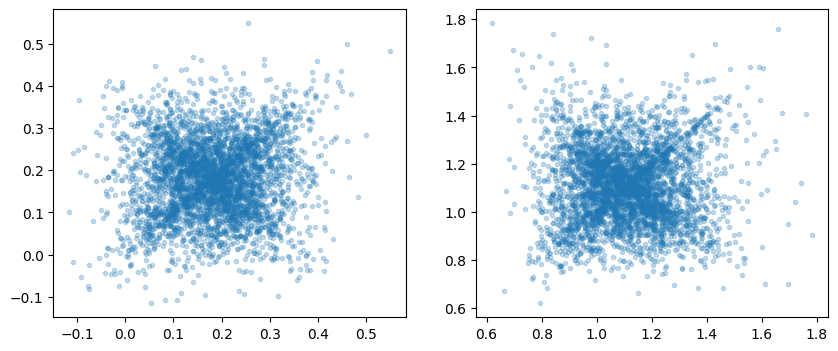

In [63]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1], 
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1], 
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                          Draws   Tuning   Steps out   Steps in   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    0           0          3153.62 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    0           0          3069.73 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    0           1          2608.58 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2000    False    1           3          1147.01 draws/s   0:00:01   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.10   -0.01     0.36        0.0      0.0   3708.21   2754.05   
tau    1.10  0.16    0.83     1.41        0.0      0.0   3789.15   2643.51   

       r_hat  
theta    1.0  
tau      1.0

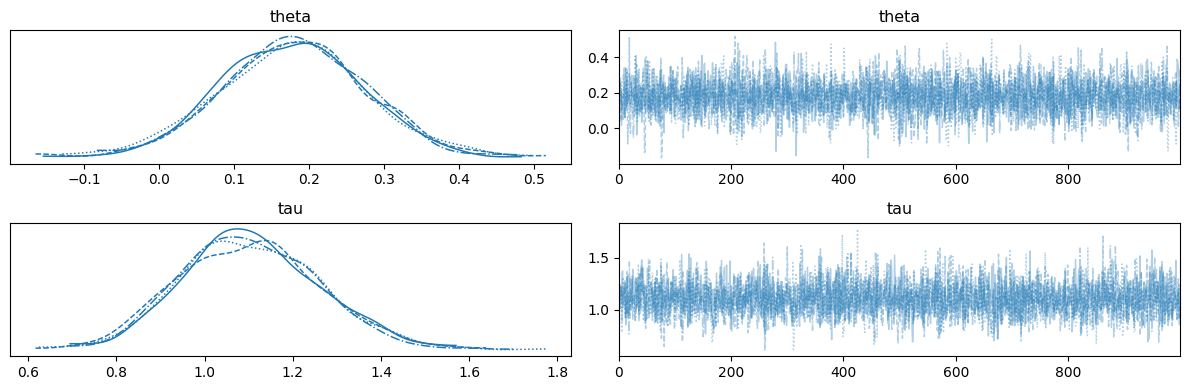

In [64]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()    

In [65]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

In [66]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

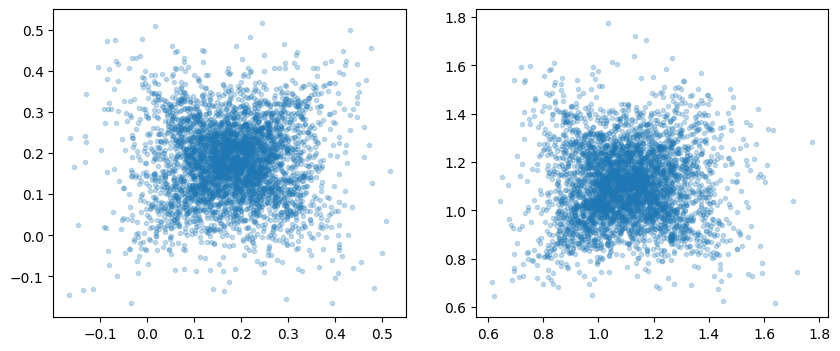

In [67]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      1.06          2519.26 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      0.00          2414.58 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      0.00          2174.23 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    1.00      0.00          666.36 draws/s    0:00:01   0:00:00

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.17  0.09    0.00     0.35       0.01      0.0    277.45    251.53   
tau    1.11  0.16    0.83     1.40       0.01      0.0    520.83    483.40   

       r_hat  
theta   1.01  
tau     1.01

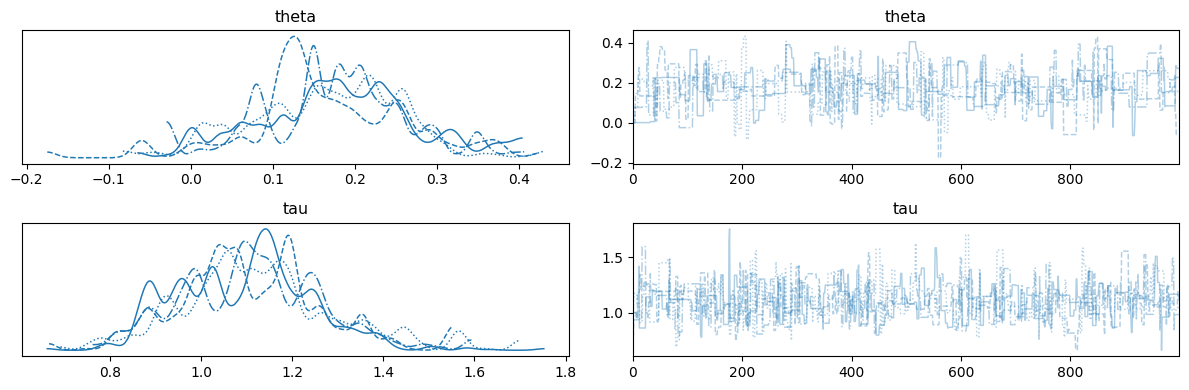

In [68]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()    

In [69]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.87987988, 0.88888889, 0.88288288, 0.88588589])

In [70]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.82482482, 0.7987988 , 0.81081081, 0.82782783])

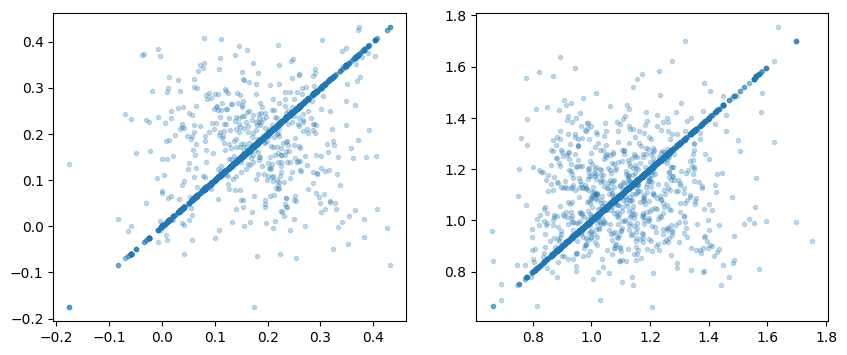

In [71]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

 Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      1.32          2681.44 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      0.23          2498.68 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      1.01          2277.89 draws/s   0:00:00   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1000    False    0.10      0.86          655.02 draws/s    0:00:01   0:00:00

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.10    0.00     0.36       0.00     0.00    509.09    723.73   
tau    1.12  0.16    0.82     1.41       0.01     0.01    275.83    414.49   

       r_hat  
theta   1.01  
tau     1.01

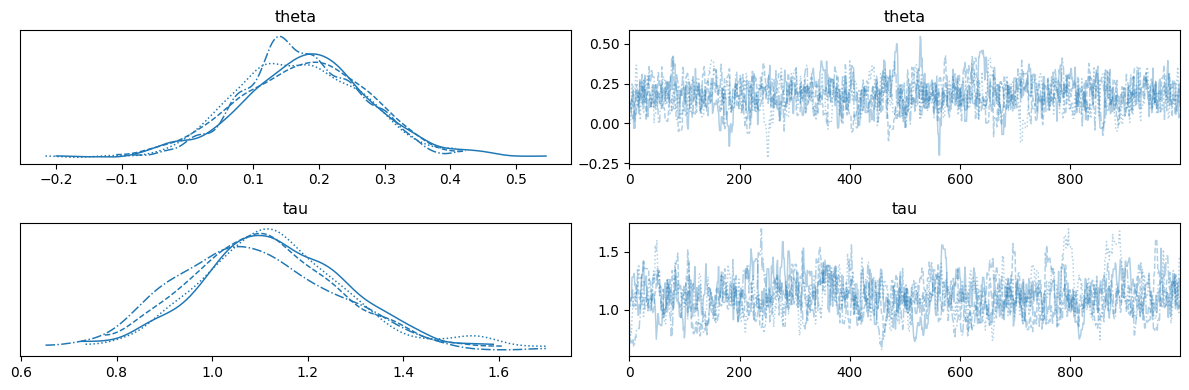

In [72]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()    

In [73]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

array([0.31631632, 0.31831832, 0.32432432, 0.31831832])

In [74]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

array([0.1961962 , 0.22322322, 0.21121121, 0.21921922])

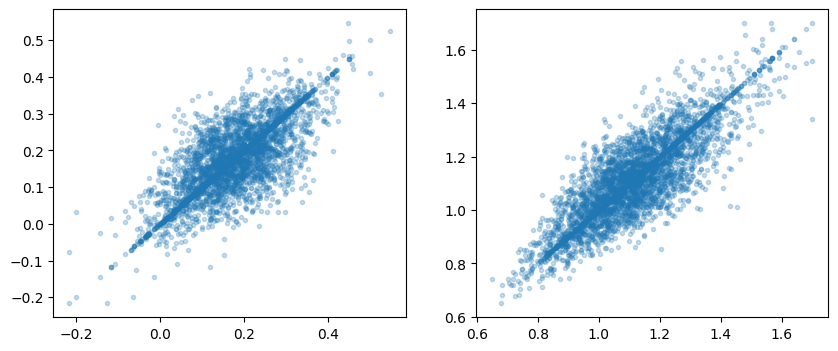

In [75]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- Distribution Dimensionality
- PyMC and PyTensor
- Using Data Containers

| | | |
|-|-|-|
|1|2|3|


#### Etc.

- 1.
- 2.
- 3.
- 4.
- 5.
- 6.
- 7.
- 8.
- 9.
- 10.
- 11.
- 12.
- 13.


| | | | |
|-|-|-|-|
|1|2|3|4|
|5|6|7|8|
|9|10|11|12|

Etc.


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [ ]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


In [ ]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

# Answers

### Q1:

In [48]:
import urllib3

from IPython.display import display, HTML

url = 'https://raw.githubusercontent.com/Lleyton-Ariton/sta365-solutions/refs/heads/main/resources.html'

response = urllib3.request('GET', url)

display(
    HTML(
        '<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 64em; }</style>'
        + response.data.decode('utf-8')
    )
)

### Q2:

In [17]:
import pymc as pm
import numpy as np

import scipy.stats as stats

import arviz as az
import matplotlib.pyplot as plt

Now, we will generate some example data $X$ from a $Normal(\mu=1, \sigma^{2}=2)$ distribution:

In [18]:
# Distribution and data parameters.
n, m, s = 30, 1, np.sqrt(2)

# Generating data.
x = np.random.normal(loc=m, scale=s, size=n)

We can use *PyMC* to perform Bayesian inference for the parameters of the data, which we will denote $\theta$ and $\tau$.

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.01        7            1328.28 draws/s   0:00:07   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.01        3            1184.59 draws/s   0:00:08   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.703  0.008   0.688    0.718      0.000    0.000   21323.0   15646.0   
tau    5.148  0.134   4.899    5.400      0.002    0.001    4784.0    5683.0   

       r_hat  
theta    1.0  
tau      1.0

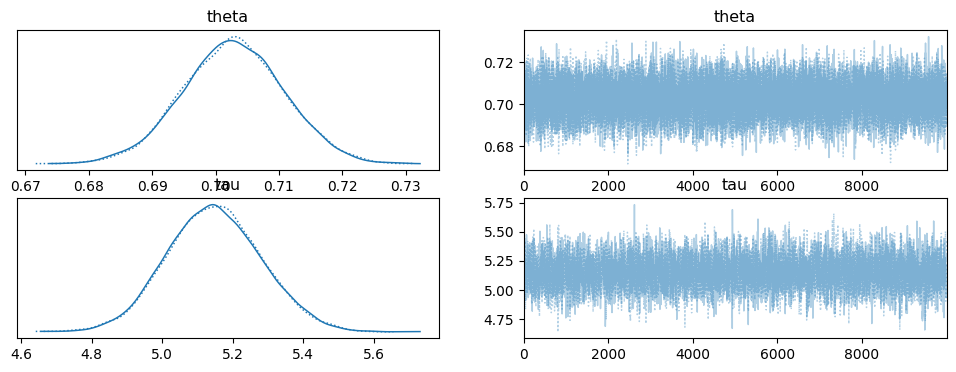

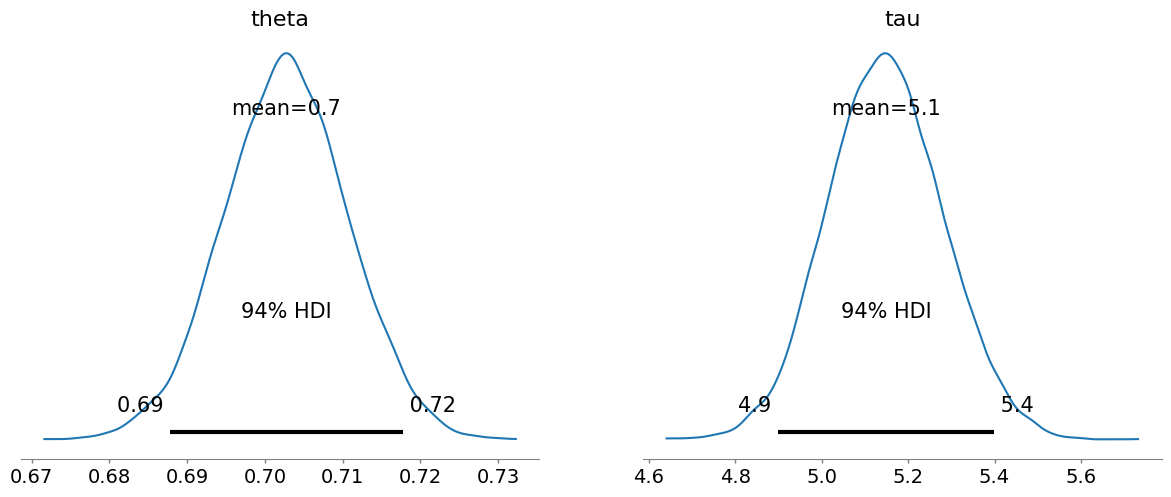

In [24]:
# Define the PyMC model using the following priors:
#    θ: Normal distribution
#    τ: Gamma distribution
with pm.Model() as model:
    
    # Initializing the prior for θ.
    theta = pm.Normal('theta', mu=0, sigma=10)
    
    # Initializing the prior for τ.
    tau = pm.Gamma('tau', alpha=(1 / 2), beta=(1 / 2))
    
    # Initializing likelihood.
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=x)
    
    # Performing Bayesian inference.
    trace = pm.sample(10000, tune=100, chains=2, return_inferencedata=True)

# Viewing diagnostics and assessments.
az.plot_trace(trace)
az.plot_posterior(trace)

az.summary(trace)

As another example, we will perform inference wherein this time the prior for theta is a non normal distribution and the prior for tau is a non-gamma distribution.

In [23]:
# Define the PyMC model using the following priors:
#    θ: Logistic distribution
#    τ: Exponential distribution
with pm.Model() as model:
    
    # Initializing the prior for θ.
    theta = pm.Logistic('theta', mu=0, s=10)
    
    # Initializing the prior for τ.
    tau = pm.Exponential('tau', lam=(1 / 2))
    
    # Initializing likelihood.
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=x)
    
    # Performing Bayesian inference.
    trace = pm.sample(10000, tune=100, chains=2, return_inferencedata=True)

# Viewing diagnostics and assessments.
az.plot_trace(trace)
az.plot_posterior(trace)

az.summary(trace)

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.01        3            1379.64 draws/s   0:00:07   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.02        7            1128.00 draws/s   0:00:08   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.703  0.008   0.687    0.717      0.000    0.000   22078.0   15692.0   
tau    5.152  0.130   4.906    5.397      0.002    0.001    5444.0    5675.0   

       r_hat  
theta    1.0  
tau      1.0

For a final demonstration, we will change the priors for the parameters again:

 Progress                   Draws   Divergences   Step size   Grad evals   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.02        15           1290.24 draws/s   0:00:07   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━   10100   0             0.01        11           1124.36 draws/s   0:00:08   0:00:00

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.703  0.008   0.688    0.718      0.000    0.000   22871.0   14928.0   
tau    5.151  0.133   4.898    5.396      0.002    0.001    5416.0    6013.0   

       r_hat  
theta    1.0  
tau      1.0

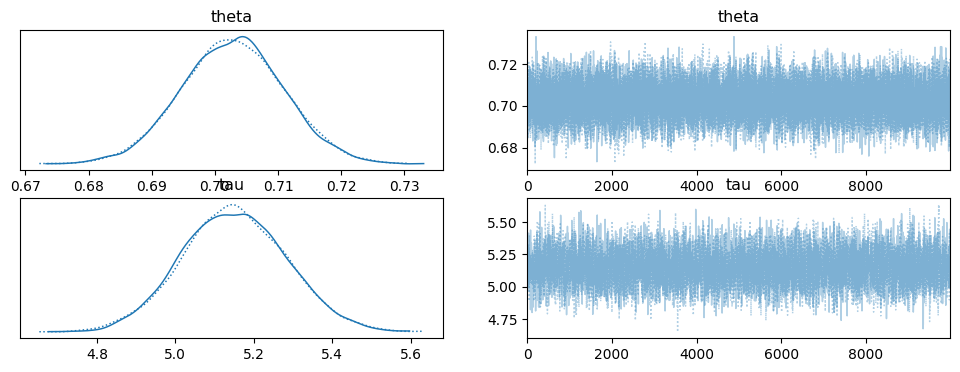

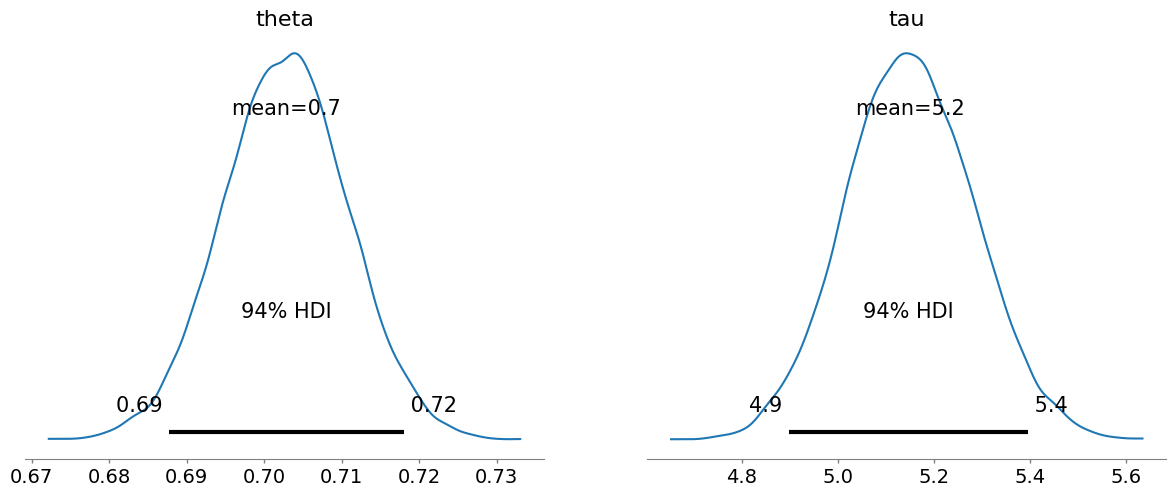

In [25]:
# Define the PyMC model using the following priors:
#    θ: Laplace distribution
#    τ: Weibull distribution
with pm.Model() as model:
    
    # Initializing the prior for θ.
    theta = pm.Laplace('theta', mu=0, b=10)
    
    # Initializing the prior for τ.
    tau = pm.Weibull('tau', alpha=(1 / 2), beta=(1 / 2))
    
    # Initializing the likelihood.
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=x)
    
    # Performing Bayesian inference.
    trace = pm.sample(10000, tune=100, chains=2, return_inferencedata=True)

# Viewing diagnostics and assessments.
az.plot_trace(trace)
az.plot_posterior(trace)

az.summary(trace)

### Q3:

The slice sampling code below works as follows:

First, we start with an initial point `x` and a curve `f`. In the case of the example code, we have `f` as the pdf for the $Beta(1.5, 3)$ distribution. Then, we sample a value `y` uniformly from the interval $(0, f(x))$. This `y` becomes our *slice* under the curve, wherein we now search for an interval $(a, b)$ that contains `x` with the condition that $f(x) \gt y$.

Then, draw a random point `x_` uniformly from the interval $(a, b)$. If $f(x\_) \gt y$, accept `x_` as the new sample.

In the case that `x_` is not accepeted and `x_ < x`, we narrow the interval by setting the left boundary to `x_`. Similarly, if `x_ > x`, we narrow the interval by setting the right boundary to `x_`.

This sample then narrow step will be continuously repeated until a valid `x_` is found.

Finally, we use the found `x_` as the new starting point for a subsequent iteration.

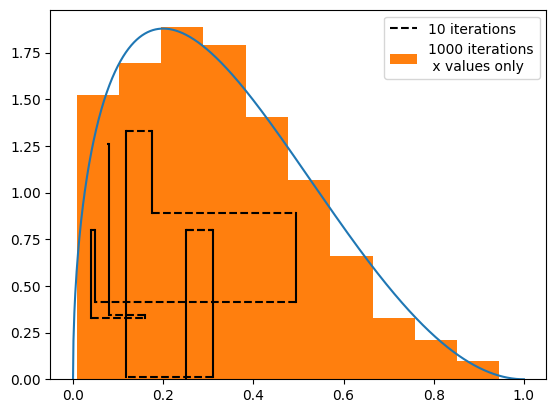

In [22]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

We can perform slice-within-Gibbs sampling as follows:

For whichever parameter $\theta_{i, t}$ we wish to estimate, we can define the curve `f` as the unnormalized full conditional distribution $p(θ_{i, t + 1} | θ_{i, t}, x)$. We can use `slice_f_at_y` as the step to draw a new value for $\theta_{i}$, then use it as an update to bring about $\theta_{i, t + 1}$. The initial value for each Gibbs step is the current value of the parameter being updated. As usual, this process can be repeated arbitrarily, hence effectively performing Gibbs sampling.